In [1]:
import pandas as pd

In [2]:
flights = pd.read_csv('../../../large_files/flights_1_1000000.csv')
for i in range(2,17):
    flights = flights.append(pd.read_csv(f'../../../large_files/flights_{1+(i-1)*10**6}_{i*10**6}.csv'),ignore_index=True)
flights.drop(columns=['rownum'],inplace=True)
f_samp = flights.sample(1000000)
f_samp.head()

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,total_add_gtime,longest_add_gtime,no_name
5131607,2018-08-27,WN,WN,WN,1972,WN,N7742B,1972,10800,BUR,...,223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2115923,2018-04-13,AA,AA,AA,2810,AA,N7548A,2810,15016,STL,...,550.0,4.0,0.0,19.0,0.0,0.0,NaN,NaN,NaN,NaN
643931,2018-02-03,AA,AA_CODESHARE,AA,4968,PT,N641AE,4968,10990,CHO,...,210.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
477693,2018-01-25,AA,AA,AA,2527,AA,N971NN,2527,14107,PHX,...,2153.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14825905,2019-11-11,AA,AA,AA,2389,AA,N9016,2389,11298,DFW,...,604.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
flights.shape

(15927485, 42)

In [50]:
f_samp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 6255880 to 14256527
Data columns (total 42 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   fl_date              1000000 non-null  object 
 1   mkt_unique_carrier   1000000 non-null  object 
 2   branded_code_share   1000000 non-null  object 
 3   mkt_carrier          1000000 non-null  object 
 4   mkt_carrier_fl_num   1000000 non-null  int64  
 5   op_unique_carrier    1000000 non-null  object 
 6   tail_num             996826 non-null   object 
 7   op_carrier_fl_num    1000000 non-null  int64  
 8   origin_airport_id    1000000 non-null  int64  
 9   origin               1000000 non-null  object 
 10  origin_city_name     1000000 non-null  object 
 11  dest_airport_id      1000000 non-null  int64  
 12  dest                 1000000 non-null  object 
 13  dest_city_name       1000000 non-null  object 
 14  crs_dep_time         1000000 non-null  int6

In [4]:
import seaborn as sns
from scipy import stats

## Arrival delays

In [7]:
# get outliers from z-score
delays_arr = f_samp['arr_delay'].dropna()
z_arr = stats.zscore(delays_arr)
z_arr

array([ 1.40633699, -0.15063926, -0.98901109, ..., -0.21052296,
        0.20866295, -0.56982517])

Mean delay in minutes: 1.032619949167488
Variance of delays in minutes-squared: 801.1912106334742
p-value result for normality of distribution of delays: 0.0


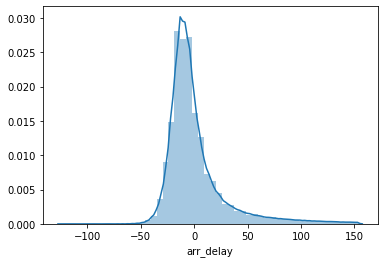

In [52]:
# Plot distribution by removing z-score>3
sns.distplot(delays_arr.loc[(abs(z_arr)<3)])
print(f'Mean delay in minutes: {delays_arr.loc[(abs(z_arr)<3)].mean()}')
print(f'Variance of delays in minutes-squared: {delays_arr.loc[(abs(z_arr)<3)].var()}')
res, p = stats.shapiro(delays_arr.loc[(abs(z_arr)<3)])
print(f'p-value result for normality of distribution of delays: {p}')

In [53]:
# Null-hypothesis -> pop_mean = 0
res_t, p_t = stats.ttest_1samp(delays_arr.loc[(abs(z_arr)<3)],popmean=0)
print(f'p-value for 1-way t-test against population of 0 minutes: {p_t}')

p-value for 1-way t-test against population of 0 minutes: 8.925113975488513e-281


In [5]:
from sklearn.neighbors import LocalOutlierFactor

In [8]:
clf = LocalOutlierFactor() # density-based approach
delay_no_outs_arr = delays_arr[(clf.fit_predict(delays_arr.to_numpy().reshape(-1,1)) != -1)] # value of -1 are outliers

Mean delay in minutes: 5.406873685467354
Variance of delays in minutes-squared: 2427.2243302564607
p-value result for normality of distribution of delays: 0.0


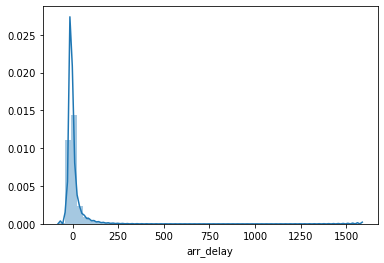

In [55]:
sns.distplot(delay_no_outs_arr)
print(f'Mean delay in minutes: {delay_no_outs_arr.mean()}')
print(f'Variance of delays in minutes-squared: {delay_no_outs_arr.var()}')
res, p = stats.shapiro(delay_no_outs_arr)
print(f'p-value result for normality of distribution of delays: {p}')

In [12]:
unique, counts = np.unique(clf.fit_predict(delays_arr.to_numpy().reshape(-1,1)),return_counts=True)
dict(zip(unique,counts))

{-1: 164, 1: 980131}

In [26]:
res_t, p_t = stats.ttest_1samp(delay_no_outs_arr,popmean=0)
print(f'p-value for 1-way t-test against population of 0 minutes: {p_t}')

p-value for 1-way t-test against population of 0 minutes: 5.772884938496731e-253


## Departure delays

In [27]:
# get outliers from z-score
delays_dep = f_samp['dep_delay'].dropna()
z_dep = stats.zscore(delays_dep)
z_dep

array([-0.41554567, -0.26706335, -0.18221632, ..., -0.41554567,
        0.43292471, -0.35191039])

Mean delay in minutes: 6.145240654978498
Variance of delays in minutes-squared: 606.949225913953
p-value result for normality of distribution of delays: 0.0


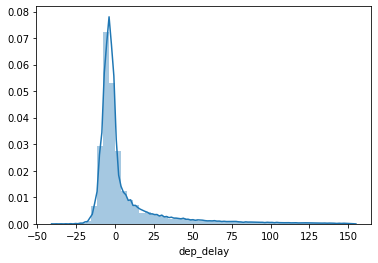

In [29]:
# Plot distribution by removing z-score>3
sns.distplot(delays_dep.loc[(abs(z_dep)<3)])
print(f'Mean delay in minutes: {delays_dep.loc[(abs(z_dep)<3)].mean()}')
print(f'Variance of delays in minutes-squared: {delays_dep.loc[(abs(z_dep)<3)].var()}')
res, p = stats.shapiro(delays_dep.loc[(abs(z_dep)<3)])
print(f'p-value result for normality of distribution of delays: {p}')

In [30]:
# Null-hypothesis -> pop_mean = 0
res_t, p_t = stats.ttest_1samp(delays_dep.loc[(abs(z_dep)<3)],popmean=0)
print(f'p-value for 1-way t-test against population of 0 minutes: {p_t}')

p-value for 1-way t-test against population of 0 minutes: 0.0


In [31]:
clf = LocalOutlierFactor() # density-based approach
delay_no_outs_dep = delays_dep[(clf.fit_predict(delays_dep.to_numpy().reshape(-1,1)) != -1)] # value of -1 are outliers

Mean delay in minutes: 10.319574091228356
Variance of delays in minutes: 2122.1083644590535
p-value result for normality of distribution of delays: 0.0


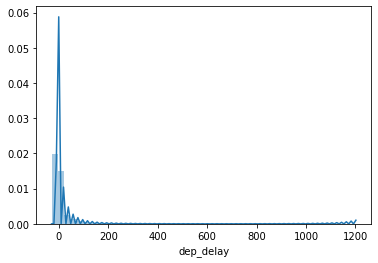

In [32]:
sns.distplot(delay_no_outs_dep)
print(f'Mean delay in minutes: {delay_no_outs_dep.mean()}')
print(f'Variance of delays in minutes: {delay_no_outs_dep.var()}')
res, p = stats.shapiro(delay_no_outs_dep)
print(f'p-value result for normality of distribution of delays: {p}')

In [33]:
res_t, p_t = stats.ttest_1samp(delay_no_outs_dep,popmean=0)
print(f'p-value for 1-way t-test against population of 0 minutes: {p_t}')

p-value for 1-way t-test against population of 0 minutes: 0.0


In [3]:
import datetime

In [34]:
# some departure delay can be caught up in-flight
print(f_samp['dep_delay'].groupby(pd.to_datetime(f_samp['fl_date'],format='%Y-%m-%d').apply(lambda x: x.month)).mean())
print(f_samp['dep_delay'].groupby(pd.to_datetime(f_samp['fl_date'],format='%Y-%m-%d').apply(lambda x: x.month)).median())
print(f_samp['arr_delay'].groupby(pd.to_datetime(f_samp['fl_date'],format='%Y-%m-%d').apply(lambda x: x.month)).mean())
print(f_samp['arr_delay'].groupby(pd.to_datetime(f_samp['fl_date'],format='%Y-%m-%d').apply(lambda x: x.month)).median())

fl_date
1      9.411456
2     11.640479
3      9.304939
4      9.827073
5     10.898733
6     14.200233
7     13.361245
8     13.343441
9      7.283623
10     7.278171
11     8.586035
12    11.494776
Name: dep_delay, dtype: float64
fl_date
1    -3.0
2    -2.0
3    -2.0
4    -3.0
5    -2.0
6    -1.0
7    -2.0
8    -2.0
9    -3.0
10   -3.0
11   -3.0
12   -2.0
Name: dep_delay, dtype: float64
fl_date
1      3.456354
2      6.814986
3      3.442664
4      4.813378
5      6.074233
6     10.050193
7      8.774168
8      8.972197
9      2.114777
10     2.277121
11     3.402474
12     5.611604
Name: arr_delay, dtype: float64
fl_date
1    -7.0
2    -6.0
3    -7.0
4    -6.0
5    -5.0
6    -4.0
7    -5.0
8    -5.0
9    -8.0
10   -7.0
11   -7.0
12   -6.0
Name: arr_delay, dtype: float64


In [48]:
f_samp.groupby(pd.to_datetime(f_samp['fl_date'],format='%Y-%m-%d').apply(lambda x: x.month)).size()

fl_date
1     7921
2     7113
3     8587
4     8201
5     8571
6     8758
7     8904
8     8954
9     8133
10    8539
11    8099
12    8220
dtype: int64

# Passenger data

In [38]:
passengers = pd.read_csv('../../../large_files/passengers.csv')
for i in range(2,4):
    passengers = passengers.append(pd.read_csv(f'../../../large_files/passengers_{1+(i-1)*10**6}_{i*10**6}.csv'),ignore_index=True)
passengers.drop(columns=['rownum'],inplace=True)
p_samp = passengers.sample(1000000)
p_samp.head()

,departures_scheduled,departures_performed,payload,seats,passengers,freight,mail,distance,ramp_to_ramp,air_time,...,dest_country,dest_country_name,aircraft_group,aircraft_type,aircraft_config,year,month,distance_group,class,data_source
922638,1.0,1.0,32700.0,124.0,117.0,65.0,0.0,762.0,155.0,125.0,...,US,United States,6,612,1,2017,10,2,F,DU
386050,38.0,38.0,1575000.0,6308.0,5781.0,9.0,0.0,733.0,5947.0,4332.0,...,US,United States,6,614,1,2019,8,2,F,DU
970174,2.0,2.0,27600.0,100.0,76.0,0.0,0.0,100.0,132.0,67.0,...,US,United States,4,484,1,2017,4,1,F,DU
1510345,16.0,16.0,118400.0,592.0,381.0,0.0,0.0,429.0,1392.0,1027.0,...,US,United States,6,674,1,2015,2,1,F,DU
1700797,26.0,25.0,320000.0,1250.0,1059.0,0.0,0.0,622.0,3007.0,2483.0,...,US,United States,6,629,1,2015,5,2,F,DU


In [39]:
p_samp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 922638 to 1466472
Data columns (total 38 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   departures_scheduled   1000000 non-null  float64
 1   departures_performed   1000000 non-null  float64
 2   payload                1000000 non-null  float64
 3   seats                  1000000 non-null  float64
 4   passengers             1000000 non-null  float64
 5   freight                1000000 non-null  float64
 6   mail                   1000000 non-null  float64
 7   distance               1000000 non-null  float64
 8   ramp_to_ramp           1000000 non-null  float64
 9   air_time               1000000 non-null  float64
 10  unique_carrier         1000000 non-null  object 
 11  airline_id             1000000 non-null  int64  
 12  unique_carrier_name    1000000 non-null  object 
 13  region                 1000000 non-null  object 
 14  carrier      

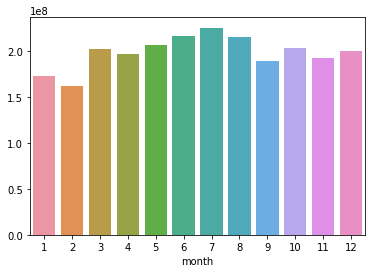

In [45]:
# distribution of passengers MEAN
sns.barplot((p_samp['passengers']).groupby(p_samp['month']).sum().index,(p_samp['passengers']).groupby(p_samp['month']).sum().values)

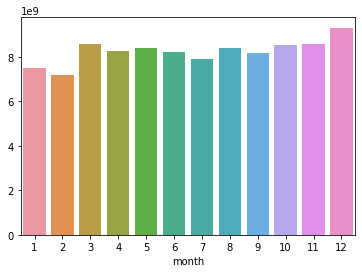

In [46]:
# distribution of freight MEAN
sns.barplot((p_samp['freight']).groupby(p_samp['month']).sum().index,(p_samp['freight']).groupby(p_samp['month']).sum().values)

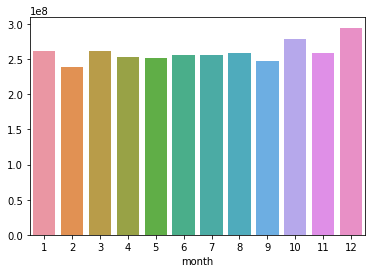

In [47]:
# distribution of mail MEAN
sns.barplot((p_samp['mail']).groupby(p_samp['month']).sum().index,(p_samp['mail']).groupby(p_samp['month']).sum().values)

## Cities in flights

In [23]:
print(f"There are {len(flights['origin_airport_id'].value_counts())} airports listed as origin")
print(f"There are {len(flights['dest_airport_id'].value_counts())} airports listed as destination")

There are 376 airports listed as origin
There are 376 airports listed as destination


In [42]:
print('One city per state = 50 states * 365 days * 2 years', 50*365*2)

One city per state = 50 states * 365 days * 2 years 36500


In [4]:
cities = pd.DataFrame(flights['origin_city_name'].unique(),columns=['city, ST'])
cities

,"city, ST"
0,"Austin, TX"
1,"Boston, MA"
2,"New York, NY"
3,"Savannah, GA"
4,"Newark, NJ"
...,...
363,"Del Rio, TX"
364,"Cheyenne, WY"
365,"Everett, WA"
366,"Pierre, SD"


In [15]:
flights['origin_city_name'].value_counts().sort_values()

Youngstown/Warren, OH         2
Bullhead City, AZ            45
King Salmon, AK             124
Rota, TT                    150
Dillingham, AK              166
                          ...  
Denver, CO               551833
Dallas/Fort Worth, TX    584649
New York, NY             600119
Atlanta, GA              786758
Chicago, IL              961219
Name: origin_city_name, Length: 368, dtype: int64

In [208]:
cities.drop(cities_samp.index,inplace=True)
cities

,"city, ST"
22,"Richmond, VA"
70,"Fayetteville, NC"
73,"Louisville, KY"
108,"Ontario, CA"
145,"Montgomery, AL"
157,"Fargo, ND"
181,"Trenton, NJ"
183,"College Station/Bryan, TX"
214,"Hayden, CO"
232,"Nome, AK"


In [16]:
import datetime
#f_samp.groupby(pd.to_datetime(f_samp['fl_date'],format='%Y-%m-%d').apply(lambda x: x.date)).size()
#cities_samp = cities#.sample(50)
weather_data_for = {}
for i in cities_samp:
    try:
        dates_samp = flights[(flights['origin_city_name']==i) & (flights['fl_date']<='2018-08-18')]['fl_date'].sample(1)
        weather_data_for.update({i:[dates_samp.values[0], (pd.to_datetime(dates_samp.values[0],format='%Y-%m-%d')+datetime.timedelta(days=499)).strftime("%Y-%m-%d")]})
    except:
        print(i)

Prescott, AZ
Kearney, NE
Del Rio, TX
Cheyenne, WY
Everett, WA
Pierre, SD
Watertown, SD


In [14]:
dates_samp.values[0]

'2018-07-18'

In [17]:
weather_data_for

{'Fort Lauderdale, FL': ['2018-06-26', '2019-11-07'],
 'Daytona Beach, FL': ['2018-04-04', '2019-08-16'],
 'Columbia, SC': ['2018-03-21', '2019-08-02'],
 'Gainesville, FL': ['2018-07-30', '2019-12-11'],
 'Fort Smith, AR': ['2018-07-30', '2019-12-11'],
 'Sioux Falls, SD': ['2018-06-20', '2019-11-01'],
 'Lincoln, NE': ['2018-02-21', '2019-07-05'],
 'Cedar Rapids/Iowa City, IA': ['2018-01-06', '2019-05-20'],
 'San Luis Obispo, CA': ['2018-05-16', '2019-09-27'],
 'Guam, TT': ['2018-05-01', '2019-09-12'],
 'Saipan, TT': ['2018-04-27', '2019-09-08'],
 'Williston, ND': ['2018-05-12', '2019-09-23'],
 'Kalispell, MT': ['2018-03-22', '2019-08-03'],
 'Punta Gorda, FL': ['2018-02-13', '2019-06-27'],
 'Medford, OR': ['2018-07-04', '2019-11-15'],
 'Idaho Falls, ID': ['2018-07-03', '2019-11-14'],
 'Cape Girardeau, MO': ['2018-06-30', '2019-11-11'],
 'Brainerd, MN': ['2018-05-16', '2019-09-27'],
 'Paducah, KY': ['2018-07-12', '2019-11-23'],
 'Salina, KS': ['2018-06-12', '2019-10-24']}

In [18]:
# FROM JAN 1ST + 500 = MAY 16 2019
# FROM AUGUST 18TH + 500 = DEC 31 2019
import numpy as np

In [19]:
import requests

url = "https://visual-crossing-weather.p.rapidapi.com/history"

headers = {
    'x-rapidapi-host': "visual-crossing-weather.p.rapidapi.com",
    'x-rapidapi-key': "0594905473msh406a02011b02770p1abb30jsn85d24aae8c4f"
    }
#weather = pd.DataFrame(data=None, columns=['city_name', 'fl_date', 'conditions']) 
for i in weather_data_for.keys():
    querystring = {"contentType":"json","startDateTime":f"{weather_data_for[i][0]}T00:00:00","aggregateHours":"24","location":f"{i}","endDateTime":f"{weather_data_for[i][1]}T00:00:00","unitGroup":"us"}

    response = requests.request("GET", url, headers=headers, params=querystring)
    #print(response.text)
    resp_j = response.json()
    try:
        value_nb = len(resp_j['locations'][i]['values'])
        for j in range(0,value_nb):
            date_frcst = resp_j['locations'][i]['values'][j]['datetimeStr'][0:10]
            frcst = resp_j['locations'][i]['values'][j]['conditions']
            weather = weather.append(pd.DataFrame([[i,date_frcst,frcst]],columns = ['city_name', 'fl_date', 'conditions']))
    except:
        print(i)

Guam, TT
Saipan, TT


In [20]:
#weather.to_csv('weather_data.csv',index=False)
weather = pd.read_csv('weather_data.csv')
weather

,city_name,fl_date,conditions
0,"Kotzebue, AK",2018-04-01,Clear
1,"Kotzebue, AK",2018-04-02,Partially cloudy
2,"Kotzebue, AK",2018-04-03,Clear
3,"Kotzebue, AK",2018-04-04,Clear
4,"Kotzebue, AK",2018-04-05,Partially cloudy
...,...,...,...
179032,"Salina, KS",2019-10-20,"Rain, Clear"
179033,"Salina, KS",2019-10-21,Partially cloudy
179034,"Salina, KS",2019-10-22,Clear
179035,"Salina, KS",2019-10-23,Clear


In [21]:
#cities_samp = flights[~flights['origin_city_name'].isin(weather.city_name.unique())]['origin_city_name'].unique()
#cities_samp

In [22]:
weather['is_sunny'] = 0
weather['is_cloudy'] = 0
weather['is_rain'] = 0
weather['is_snow'] = 0
weather.head()

,city_name,fl_date,conditions,is_sunny,is_cloudy,is_rain,is_snow
0,"Kotzebue, AK",2018-04-01,Clear,0,0,0,0
1,"Kotzebue, AK",2018-04-02,Partially cloudy,0,0,0,0
2,"Kotzebue, AK",2018-04-03,Clear,0,0,0,0
3,"Kotzebue, AK",2018-04-04,Clear,0,0,0,0
4,"Kotzebue, AK",2018-04-05,Partially cloudy,0,0,0,0


In [23]:
weather['conditions'].unique()

array(['Clear', 'Partially cloudy', 'Rain, Partially cloudy',
       'Rain, Overcast', 'Overcast', 'Rain, Clear',
       'Snow, Partially cloudy', 'Snow, Overcast', 'Snow, Clear'],
      dtype=object)

In [24]:
weather.loc[weather[weather.conditions=='Clear'].index,'is_sunny'] = 1
weather.loc[weather[weather.conditions=='Partially cloudy'].index,'is_cloudy'] = 1
weather.loc[weather[weather.conditions=='Rain, Partially cloudy'].index,'is_cloudy'] = 1
weather.loc[weather[weather.conditions=='Rain, Partially cloudy'].index,'is_rain'] = 1
weather.loc[weather[weather.conditions=='Rain, Overcast'].index,'is_cloudy'] = 1
weather.loc[weather[weather.conditions=='Rain, Overcast'].index,'is_rain'] = 1
weather.loc[weather[weather.conditions=='Overcast'].index,'is_cloudy'] = 1
weather.loc[weather[weather.conditions=='Rain, Clear'].index,'is_rain'] = 1
weather.loc[weather[weather.conditions=='Rain, Clear'].index,'is_sunny'] = 1
weather.loc[weather[weather.conditions=='Snow, Partially cloudy'].index,'is_snow'] = 1
weather.loc[weather[weather.conditions=='Snow, Partially cloudy'].index,'is_cloudy'] = 1
weather.loc[weather[weather.conditions=='Snow, Overcast'].index,'is_snow'] = 1
weather.loc[weather[weather.conditions=='Snow, Overcast'].index,'is_cloudy'] = 1
weather.loc[weather[weather.conditions=='Snow, Clear'].index,'is_snow'] = 1
weather.loc[weather[weather.conditions=='Snow, Clear'].index,'is_sunny'] = 1
weather.head(20)

,city_name,fl_date,conditions,is_sunny,is_cloudy,is_rain,is_snow
0,"Kotzebue, AK",2018-04-01,Clear,1,0,0,0
1,"Kotzebue, AK",2018-04-02,Partially cloudy,0,1,0,0
2,"Kotzebue, AK",2018-04-03,Clear,1,0,0,0
3,"Kotzebue, AK",2018-04-04,Clear,1,0,0,0
4,"Kotzebue, AK",2018-04-05,Partially cloudy,0,1,0,0
5,"Kotzebue, AK",2018-04-06,"Rain, Partially cloudy",0,1,1,0
6,"Kotzebue, AK",2018-04-07,"Rain, Partially cloudy",0,1,1,0
7,"Kotzebue, AK",2018-04-08,Clear,1,0,0,0
8,"Kotzebue, AK",2018-04-09,Clear,1,0,0,0
9,"Kotzebue, AK",2018-04-10,Clear,1,0,0,0


In [3]:
#weather.to_csv('weather_data.csv',index=False)
weather = pd.read_csv('weather_data.csv')
weather

,city_name,fl_date,conditions,is_sunny,is_cloudy,is_rain,is_snow
0,"Kotzebue, AK",2018-04-01,Clear,1,0,0,0
1,"Kotzebue, AK",2018-04-02,Partially cloudy,0,1,0,0
2,"Kotzebue, AK",2018-04-03,Clear,1,0,0,0
3,"Kotzebue, AK",2018-04-04,Clear,1,0,0,0
4,"Kotzebue, AK",2018-04-05,Partially cloudy,0,1,0,0
...,...,...,...,...,...,...,...
179032,"Salina, KS",2019-10-20,"Rain, Clear",1,0,1,0
179033,"Salina, KS",2019-10-21,Partially cloudy,0,1,0,0
179034,"Salina, KS",2019-10-22,Clear,1,0,0,0
179035,"Salina, KS",2019-10-23,Clear,1,0,0,0


In [16]:
import copy
cols = ['fl_date','origin_airport_id','origin_city_name', 'dest_airport_id', 'dest_city_name', 'dep_time', 'dep_delay', 'arr_time', 'arr_delay', 'cancelled', 'cancellation_code', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay' ]
#flights2 = copy.deepcopy(f_samp[cols])
flights2 = copy.deepcopy(flights)
flights2 = flights2.merge(weather, left_on = ['origin_city_name', 'fl_date'], right_on = ['city_name', 'fl_date'], how='left', indicator=True)

In [21]:
flights2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15927485 entries, 0 to 15927484
Data columns (total 49 columns):
 #   Column               Dtype   
---  ------               -----   
 0   fl_date              object  
 1   mkt_unique_carrier   object  
 2   branded_code_share   object  
 3   mkt_carrier          object  
 4   mkt_carrier_fl_num   int64   
 5   op_unique_carrier    object  
 6   tail_num             object  
 7   op_carrier_fl_num    int64   
 8   origin_airport_id    int64   
 9   origin               object  
 10  origin_city_name     object  
 11  dest_airport_id      int64   
 12  dest                 object  
 13  dest_city_name       object  
 14  crs_dep_time         int64   
 15  dep_time             float64 
 16  dep_delay            float64 
 17  taxi_out             float64 
 18  wheels_off           float64 
 19  wheels_on            float64 
 20  taxi_in              float64 
 21  crs_arr_time         int64   
 22  arr_time             float64 
 23  arr_d

In [24]:
flights2[flights2['_merge']=='both']

,fl_date,mkt_unique_carrier,branded_code_share,mkt_carrier,mkt_carrier_fl_num,op_unique_carrier,tail_num,op_carrier_fl_num,origin_airport_id,origin,...,total_add_gtime,longest_add_gtime,no_name,city_name,conditions,is_sunny,is_cloudy,is_rain,is_snow,_merge
618,2018-01-01,AA,AA_CODESHARE,AA,5510,OH,N213PS,5510,10980,CHA,...,NaN,NaN,NaN,"Chattanooga, TN",Partially cloudy,0.0,1.0,0.0,0.0,both
619,2018-01-01,AA,AA_CODESHARE,AA,5511,OH,N230PS,5511,10980,CHA,...,NaN,NaN,NaN,"Chattanooga, TN",Partially cloudy,0.0,1.0,0.0,0.0,both
2128,2018-01-01,DL,DL_CODESHARE,DL,3382,9E,N8888D,3382,10980,CHA,...,NaN,NaN,NaN,"Chattanooga, TN",Partially cloudy,0.0,1.0,0.0,0.0,both
2211,2018-01-01,AA,AA_CODESHARE,AA,2833,EV,N617QX,2833,13290,MHK,...,NaN,NaN,NaN,"Manhattan/Ft. Riley, KS",Clear,1.0,0.0,0.0,0.0,both
2218,2018-01-01,AA,AA_CODESHARE,AA,2840,EV,N613QX,2840,13290,MHK,...,NaN,NaN,NaN,"Manhattan/Ft. Riley, KS",Clear,1.0,0.0,0.0,0.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15884082,2019-12-29,WN,WN,WN,3137,WN,N8557Q,3137,12278,ICT,...,NaN,NaN,NaN,"Wichita, KS",Partially cloudy,0.0,1.0,0.0,0.0,both
15890210,2019-12-30,AS,AS,AS,64,AS,N619AS,64,15841,WRG,...,NaN,NaN,NaN,"Wrangell, AK","Rain, Overcast",0.0,1.0,1.0,0.0,both
15890215,2019-12-30,AS,AS,AS,65,AS,N644AS,65,15841,WRG,...,NaN,NaN,NaN,"Wrangell, AK","Rain, Overcast",0.0,1.0,1.0,0.0,both
15905466,2019-12-30,AA,AA_CODESHARE,AA,4952,PT,NaN,4952,12365,IPT,...,NaN,NaN,NaN,"Williamsport, PA","Rain, Overcast",0.0,1.0,1.0,0.0,both


In [25]:
from scipy import stats

sunny = flights2[flights2['is_sunny']==1]['dep_delay'].dropna()
cloudy = flights2[flights2['is_cloudy']==1]['dep_delay'].dropna()
rainy = flights2[flights2['is_rain']==1]['dep_delay'].dropna()
snowy = flights2[flights2['is_snow']==1]['dep_delay'].dropna()
res_anova, p_anova = stats.f_oneway(sunny,cloudy,rainy,snowy)
print(res_anova,p_anova)

8295.270433631877 0.0


In [26]:
print(sunny.mean())
print(cloudy.mean())
print(rainy.mean())
print(snowy.mean())

9.90512578398378
11.559704744374171
15.488203825865192
15.960625946491671


In [27]:
sunny.to_csv('sunny_departures.csv',index=False)
cloudy.to_csv('cloudy_departures.csv',index=False)
rainy.to_csv('rainy_departures.csv',index=False)
snowy.to_csv('snowy_departures.csv',index=False)